In [68]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [69]:
sr_path = Path(ROOT_DIR, 'results', 'sr')
r_path = Path(ROOT_DIR, 'results', 'r')
pr_path = Path(ROOT_DIR, 'results', 'pr')
pmr_path = Path(ROOT_DIR, 'results', 'pmr')
split_pr_by = ["update_weight_interval"]
pr_colors = [ 'lightseagreen', 'lime', 'limegreen', 'forestgreen', 'darkgreen', 'darkolivegreen', ]
pmr_colors = ['lightcoral', 'indianred', 'brown', 'maroon']


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [70]:
def process_dir(dir_path, key="reward", w=100, trunc=60000, split_by=None):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            if trunc > info[key].shape[0]:
                print(args)
                print(f"length of misbehaving data: {info[key].shape}")
                
            result = moving_avg(info[key][:trunc], w=w)
            all_results[split_by_tuple][hparams].append(result)
            
        else:
            result = moving_avg(info[key][:trunc], w=w)
            all_results.append(result)
    if split_by is not None:
        for k, v in all_results.items():
            for k1, v1 in v.items():
                all_results[k][k1] = np.array(all_results[k][k1])
        data = all_results
    else:
        data = np.array(all_results)

    
    return data


In [44]:
w = 100
sr_data = process_dir(sr_path, w=w)
r_data = process_dir(r_path, w=w)
pr_data = process_dir(pr_path, w=w, split_by=split_pr_by)
pmr_data = process_dir(pmr_path, w=w, split_by=split_pr_by)

In [45]:
pr_uwi_data = sorted(pr_data[('update_weight_interval',)].items(), key=lambda k: k[0][0])
pmr_uwi_data = sorted(pmr_data[('update_weight_interval',)].items(), key=lambda k: k[0][0])

In [64]:
# all_data = [('State + obs', sr_data, 'blue'), ('Obs only', r_data, 'orange'),
#             *[(f"PF + obs (n = {k[0]})", d, pr_colors[i]) for i, (k, d) in enumerate(pr_uwi_data)],
#             *[(f"PF mean + obs (n = {k[0]})", d, pmr_colors[i]) for i, (k, d) in enumerate(pmr_uwi_data[:1])]
#            ]
all_data = [(f"PF + obs (n = {k[0]})", d, pr_colors[i]) for i, (k, d) in enumerate(pr_uwi_data)]

In [47]:
normal_len = sr_data[0].shape[0]
for i, d in enumerate(sr_data):
    if d.shape[0] != normal_len:
        print(i, d.shape)

In [48]:
pr_uwi_data

[((1,),
  array([[0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.06],
         [0.  , 0.  , 0.  , ..., 0.07, 0.07, 0.07],
         [0.  , 0.  , 0.  , ..., 0.08, 0.08, 0.07],
         ...,
         [0.  , 0.  , 0.  , ..., 0.09, 0.09, 0.09],
         [0.  , 0.  , 0.  , ..., 0.1 , 0.1 , 0.1 ],
         [0.  , 0.  , 0.  , ..., 0.11, 0.11, 0.11]])),
 ((2,),
  array([[0.  , 0.  , 0.  , ..., 0.09, 0.09, 0.09],
         [0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.06],
         [0.  , 0.  , 0.  , ..., 0.08, 0.07, 0.07],
         ...,
         [0.01, 0.01, 0.01, ..., 0.1 , 0.1 , 0.1 ],
         [0.01, 0.01, 0.01, ..., 0.11, 0.11, 0.11],
         [0.  , 0.  , 0.  , ..., 0.07, 0.07, 0.08]])),
 ((5,),
  array([[0.01, 0.01, 0.01, ..., 0.05, 0.05, 0.05],
         [0.  , 0.  , 0.  , ..., 0.05, 0.05, 0.05],
         [0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.06],
         ...,
         [0.  , 0.  , 0.  , ..., 0.08, 0.07, 0.07],
         [0.  , 0.  , 0.  , ..., 0.06, 0.06, 0.05],
         [0.  , 0.  , 0.  , ..., 0.07, 0.07,

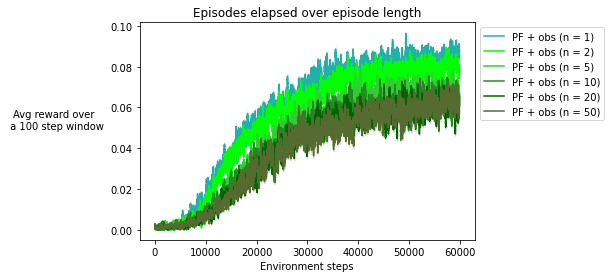

In [65]:
x = np.arange(sr_data.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Avg reward over \n a {w} step window", rotation=0, labelpad=55)
ax.set_title('Episodes elapsed over episode length')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


In [81]:
all_vars = []
trunc = 60000

for info_path in pr_path.iterdir():
    pr_info = load_info(info_path)
    args = pr_info['args'].item()
    
    if args['update_weight_interval'] == 1:
        single_particle_times = []
        all_ending_vars = []
        all_run_vars = []
        for ep, (m_ep, v_ep) in enumerate(zip(pr_info['pf_episodic_mean'][:trunc], pr_info['pf_episodic_var'][:trunc])):
            for step, (m, v) in enumerate(zip(m_ep, v_ep)):
                all_run_vars.append(v.sum())
                if np.isclose(v.sum(), 0):
                    single_particle_times.append((ep, step))
                    break

            all_ending_vars.append((ep, step, v.sum()))
        all_vars.append(np.array(all_run_vars))

In [82]:
variances = np.array(all_vars)

/tmp/ipykernel_3045/3233260353.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variances = np.array(all_vars)


In [91]:
variances[-1].shape, len(all_ending_vars)

((41665,), 4186)